# Deep neural network

This section is just an improvement of the first neural network. The major change is that a bias vector is introduced for each node and the forward propagation and backpropagation are embedded into a loop that automatically goes through the layers (in case more than 1 hidden one is present) instead of manually define the cost and the deltas as in the original example.

In [1]:
# imports and plot customizations
import os
import sys
import pickle
import collections
import copy
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import time

class TimeClass():
    def __init__(self):
        pass
    def __enter__(self):
        self.start = time.time()
    def __exit__(self, type, value, traceback):
        self.end = time.time()
        self.elapsed = round(self.end - self.start, 2)
        print('\nFinished executing in {} seconds\n'.format(self.elapsed))

In [3]:
matplotlib.rcParams['xtick.color'] = 'grey'
matplotlib.rcParams['ytick.color'] = 'grey'
matplotlib.rcParams['xtick.major.size'] = 7
matplotlib.rcParams['ytick.major.size'] = 7
# matplotlib.rcParams['xtick.labelsize'] = 10
# matplotlib.rcParams['ytick.labelsize'] = 10
matplotlib.rcParams['xtick.minor.bottom'] = False
matplotlib.rcParams['ytick.minor.left'] = False
matplotlib.rcParams['figure.titlesize'] = 15
matplotlib.rcParams['axes.titlesize'] = 15
matplotlib.rcParams['axes.labelsize'] = 15
matplotlib.rcParams['axes.labelcolor'] = 'grey'
matplotlib.rcParams['font.size'] = 15
matplotlib.rcParams['xtick.major.pad'] = 8
matplotlib.rcParams['ytick.major.pad'] = 8
matplotlib.rcParams['legend.frameon'] = False
matplotlib.rcParams['axes.edgecolor'] = 'grey'
matplotlib.rcParams['text.color'] = 'grey'
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['ytick.minor.visible'] = True
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False
matplotlib.rcParams['legend.loc'] = 'upper left'
matplotlib.rcParams['figure.constrained_layout.h_pad'] = 0.12
matplotlib.rcParams['figure.constrained_layout.w_pad'] = 0.12

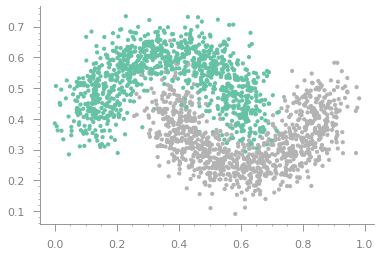

In [922]:
import sklearn.datasets, sklearn.model_selection

X, y = sklearn.datasets.make_moons(n_samples=2000, shuffle=True, noise=0.2, random_state=None)
X -= np.min(X)
X /= 4

fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], c=y, s=10, cmap='Set2')

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, train_size = 0.6)
y_train = y_train[:, np.newaxis]
y_test = y_test[:, np.newaxis]

Documentation: 
    https://ml-cheatsheet.readthedocs.io/en/latest/backpropagation.html

In [932]:
def init_layers(input_dimensionality, output_dimensionality, architecture, seed = None):
    if seed: np.random.seed(seed)  
    architecture[-1]['nodes'] = output_dimensionality
    architecture = [{'Z':None}] + architecture + [{'W':np.eye(architecture[-1]['nodes']), 'y':None}]
    architecture[0]['nodes'] = input_dimensionality
    
    for i in range(1, len(architecture) -1):
        layer_input_size = architecture[i - 1]['nodes']
        layer_output_size = architecture[i]['nodes']
        #architecture[i]['W'] = np.random.randn(layer_input_size, layer_output_size) * 0.1
        #architecture[i]['b'] = np.random.randn(1, layer_output_size) * 0.1
        architecture[i]['W'] = np.random.randn(layer_input_size, layer_output_size) * np.sqrt(2 / (layer_input_size + layer_output_size))
        architecture[i]['b'] = np.zeros((1, layer_output_size))
        architecture[i]['dropout_probability'] = architecture[i].get('dropout_probability', 0)
        
    return architecture

def dropout_mask(p, shape):
    mask = np.random.choice([0.,1.], shape, p = [p, 1 - p])
    mask *= np.multiply(*shape) / np.sum(mask)
    return mask

# activations
def sigmoid(Z_dot):
    return 1 / (1 + np.exp(-Z_dot))

def sigmoid_derivative(Z):
    sig = sigmoid(Z)
    return sig * (1 - sig)

def relu(Z_dot):
    return np.maximum(0, Z_dot)

def relu_derivative(Z):
    x = np.ones_like(Z)
    x[Z <= 0] = 0
    return x

def tanh(Z_dot):
    return np.tanh(Z_dot)
    
def tanh_derivate(Z):
    return 1 - (Z ** 2)

def softmax(Z_dot):
    Z_dot = Z_dot - np.max(Z_dot, axis = 1)[:, np.newaxis]
    x = np.exp(Z_dot)
    return x / np.sum(x, axis = 1, keepdims = True)

# costs
def binary_crossentropy(y_estimate, y): # scalar
    return np.sum(np.select([y == 1, y == 0], [- np.log(y_estimate), - np.log(1 - y_estimate)])) # same as
    # return np.sum(- y * np.log(y_estimate) - (1 - y) * np.log(1 - y_estimate))

def binary_crossentropy_derivative(y_estimate, y): # same dimensions as inputs
    return np.select([y == 1, y == 0], [y_estimate -1, y_estimate])
    
def sum_of_squares(y_estimate, y): # scalar
    return 1/2 * np.sum((y_estimate - y) ** 2) # 1/2 was added so the derivative is simply: y_estimate - y

def sum_of_squares_derivative(y_estimate, y): # same dimensions as inputs
    return y_estimate - y
            
def classification_accuracy(y_estimate, y): # scalar
    y_estimate_binary = np.select([y_estimate <= 0.5, y_estimate > 0.5], [0, 1]) 
    classification = y_estimate_binary == y
    return np.sum(classification) / y.shape[0]

def split_data(X, y, batch_size):
    # shuffle the dataset
    idx = np.random.choice(np.arange(X.shape[0]), X.shape[0], replace = False)
    X = X[idx]
    y = y[idx]
    # split
    batches = int(X.shape[0] / batch_size)
    idx = np.int32(np.linspace(0, X.shape[0], batches, endpoint = True))
    idx = zip(idx[:-1], idx[1:])
    X_y_batches = [(X[start:end], y[start:end]) for start, end in idx]
    return X_y_batches


def single_layer_forward_propagation(A, W, b, activation, mask, prediction):
    activation_func = eval(activation)
    activation_func_derivative = eval(activation + '_derivative')
    Z_dot = np.dot(A, W) + b
    Z = activation_func(Z_dot)
    Z_derivative = activation_func_derivative(Z)
    if not prediction:
        Z = Z * mask
    return Z, Z_dot, Z_derivative

def forward_propagation(architecture, cost_function = None, prediction = False):
    for i in range(1, len(architecture) - 1):
        architecture[i]['mask'] = dropout_mask(
            architecture[i]['dropout_probability'], 
            (architecture[i -1]['Z'].shape[0], architecture[i]['W'].shape[1])
        )
        (
            architecture[i]['Z'], 
            architecture[i]['Z_dot'], 
            architecture[i]['Z_derivative']
        ) = single_layer_forward_propagation(
            architecture[i -1]['Z'], 
            architecture[i]['W'], 
            architecture[i]['b'], 
            architecture[i]['activation'],
            architecture[i]['mask'],
            prediction = prediction
        )
    if cost_function:
        cost_function_derivative = eval(cost_function + '_derivative')
        architecture[-1]['cost_derivative'] = cost_function_derivative(architecture[-2]['Z'], architecture[-1]['y'])
    return architecture

def back_propagation(architecture, learning_rate_W, learning_rate_b):
    for i in reversed(range(1, len(architecture) - 1)):
        
        architecture[i]['cost_derivative'] = np.dot(
            architecture[i + 1]['cost_derivative'], 
            architecture[i + 1]['W'].T) 
        architecture[i]['cost_derivative'] /= architecture[i + 1]['cost_derivative'].shape[1]
        architecture[i]['cost_derivative'] *= architecture[i]['Z_derivative']
        architecture[i]['cost_derivative'] *= architecture[i]['mask']
        
        architecture[i]['W_delta'] = np.dot(
            architecture[i -1]['Z'].T, 
            architecture[i]['cost_derivative'])
        architecture[i]['W_delta'] /= architecture[i]['cost_derivative'].shape[0]
        
        architecture[i]['b_delta'] = np.sum(
            architecture[i]['cost_derivative'], 
            axis = 0) 
        architecture[i]['b_delta'] /= architecture[i]['cost_derivative'].shape[0]
        
        architecture[i]['b'] -= learning_rate_b * architecture[i]['b_delta']       
        architecture[i]['W'] -= learning_rate_W * architecture[i]['W_delta']       
    return architecture

def fit(X, y, architecture, cost_function, learning_rate_W, learning_rate_b, batch_size, epochs, seed = None):
    if y.ndim == 1: y = y[:, np.newaxis]  
    cost_function_ = eval(cost_function)
    architecture = init_layers(
        input_dimensionality = X.shape[1], 
        output_dimensionality = y.shape[1], 
        architecture = architecture, 
        seed = seed) 
    history = []
    accuracy = []
    cost = []
    for epoch in range(epochs):
        batches = split_data(X, y, batch_size)        
        for X_batch, y_batch in batches:
            architecture[0]['Z'] = X_batch
            architecture[-1]['y'] = y_batch
            architecture = forward_propagation(architecture, cost_function)
            architecture = back_propagation(architecture, learning_rate_W, learning_rate_b)    
        history += [ copy.deepcopy(architecture) ]
        epoch_prediction = predict(architecture, X, y)
        accuracy += [ classification_accuracy(epoch_prediction, y) ]
        cost += [ cost_function_(epoch_prediction, y) ]
        sys.stdout.write(
                "\r" +
                " Epoch:" + str(epoch + 1) + "/" + str(epochs) +
                ", Cost:" + str(cost[epoch])[0:5] + 
                ", Train accuracy:" + str(accuracy[epoch])[:5]
                )
    return history, accuracy, cost

def predict(architecture, X, y = None):
    if y is not None: 
        if y.ndim == 1: 
            y = y[:, np.newaxis]
    architecture[0]['Z'] = X
    architecture[-1]['y'] = y    
    architecture = forward_propagation(architecture, prediction = True)
    return architecture[-2]['Z']

def plot_prediction_boundaries(X, y, neural_network_object, epochs = -1, columns = 3, plots_size = 3, 
                               cmap = None, colors = ["tab:blue", 'white', "tab:olive"]):   
    space_range = zip(np.min(X, axis = 0).tolist(), np.max(X, axis = 0).tolist())
    space = list(map(lambda x: np.linspace(*x, num = 50), space_range))
    grid = np.meshgrid(*space)
    grid_flat = np.column_stack(list(map(lambda x: np.ravel(x), grid)))   
    if not cmap:
        breaks = np.linspace(0,1, num = len(colors))
        cmap = matplotlib.colors.LinearSegmentedColormap.from_list("mycmap1", list(zip(breaks, colors)), N = 50)
    rows = int(np.ceil(len(epochs)/columns))
    with matplotlib.rc_context( rc = { 
        'xtick.minor.visible': False,
        'ytick.minor.visible': False,
        'axes.spines.right': False,
        'axes.spines.top': False,
        'axes.spines.bottom':False,
        'axes.spines.left':False 
    }):
        fig, ax = plt.subplots(
            rows, 
            columns, 
            figsize = (plots_size * columns, plots_size * rows), 
            constrained_layout = True
        )
        pred_parameter_space = {}      
        for i, epoch in enumerate(epochs):
            pred_parameter_space[epoch] = predict(neural_network_object[0][epoch], grid_flat).reshape(grid[0].shape)

            ax.ravel()[i].scatter(X[:, 0], X[:, 1], c=y, s=10, cmap=cmap, alpha = 0.1)
            ax.ravel()[i].contourf(grid[0], grid[1], pred_parameter_space[epoch], alpha = 0.2, cmap = cmap)
            ax.ravel()[i].contour(grid[0], grid[1], pred_parameter_space[epoch], levels = [0.5], colors = ['grey'], linestyles = ['dashed'])
            ax.ravel()[i].set(title = 'Epoch: ' + str(epoch))
            
def plot_epoch_stats(vector, ylabel = ''):
    _, ax = plt.subplots(1,1, figsize = (4, 4))
    ax.plot(vector, color = 'grey')
    ax.set_xlabel('Epoch', color = 'grey', fontsize = 15)
    ax.set_ylabel(ylabel, color = 'grey', fontsize = 15)


In [933]:
with TimeClass():
    nn = fit(
        X_train, 
        y_train, 
        [
            {'nodes':24, 'activation':'relu', 'dropout_probability':0.1}, 
            {'nodes':8, 'activation':'relu', 'dropout_probability':0.1}, 
            {'activation':'sigmoid'}
        ], 
        cost_function = 'binary_crossentropy',
        #cost_function = 'sum_of_squares',
        learning_rate_W = 0.1,
        learning_rate_b = 0.001,
        batch_size = 20,
        epochs = 2000, 
        seed = 22
    )

 Epoch:2000/2000, Cost:176.8, Train accuracy:0.956
Finished executing in 106.53 seconds



# Deep neural network:
# Place the functions into a class

In [1105]:
class NeuralNetwork:
    def __init__(self, architecture, **kwargs):
        self.architecture = architecture
        self.epochs = int(kwargs.get('epochs', 1000))
        self.learning_rate_W = kwargs.get('learning_rate_W', 0.1)
        self.learning_rate_b = kwargs.get('learning_rate_b', 0.001)
        self.batch_size = kwargs.get('batch_size', 20)
        self.cost_function = kwargs.get('cost_function', 'sum_of_squares')
        self.seed = kwargs.get('seed', None)
        self.history = []
        self.accuracy = []
        self.cost = []
        
    @staticmethod
    def init_architecture(input_dimensionality, output_dimensionality, architecture, seed = None):
            if seed: np.random.seed(seed)  
            architecture[-1]['nodes'] = output_dimensionality
            architecture = [{'Z':None}] + architecture + [{'W':np.eye(architecture[-1]['nodes']), 'y':None}]
            architecture[0]['nodes'] = input_dimensionality

            for i in range(1, len(architecture) -1):
                layer_input_size = architecture[i - 1]['nodes']
                layer_output_size = architecture[i]['nodes']
                architecture[i]['W'] = np.random.randn(layer_input_size, layer_output_size) * np.sqrt(2 / (layer_input_size + layer_output_size))
                architecture[i]['b'] = np.zeros((1, layer_output_size))
                architecture[i]['dropout_probability'] = architecture[i].get('dropout_probability', 0)
            return architecture

    @staticmethod
    def dropout_mask(p, shape):
        mask = np.random.choice([0.,1.], shape, p = [p, 1 - p])
        mask *= np.multiply(*shape) / np.sum(mask)
        return mask

    # activations
    @staticmethod
    def sigmoid(Z_dot):
        return 1 / (1 + np.exp(-Z_dot))

    @staticmethod
    def sigmoid_derivative(Z):
        sigmoid = lambda x: 1 / (1 + np.exp(-x))
        sig = sigmoid(Z)
        return sig * (1 - sig)
    
    @staticmethod
    def relu(Z_dot):
        return np.maximum(0, Z_dot)

    @staticmethod
    def relu_derivative(Z):
        x = np.ones_like(Z)
        x[Z <= 0] = 0
        return x

    @staticmethod
    def tanh(Z_dot):
        return np.tanh(Z_dot)

    @staticmethod
    def tanh_derivate(Z):
        return 1 - (Z ** 2)

    @staticmethod
    def softmax(Z_dot):
        Z_dot = Z_dot - np.max(Z_dot, axis = 1)[:, np.newaxis]
        x = np.exp(Z_dot)
        return x / np.sum(x, axis = 1, keepdims = True)

    # costs
    @staticmethod
    def binary_crossentropy(y_estimate, y): # scalar
        return np.sum(np.select([y == 1, y == 0], [- np.log(y_estimate), - np.log(1 - y_estimate)])) # same as
        # return np.sum(- y * np.log(y_estimate) - (1 - y) * np.log(1 - y_estimate))

    @staticmethod
    def binary_crossentropy_derivative(y_estimate, y): # same dimensions as inputs
        return np.select([y == 1, y == 0], [y_estimate -1, y_estimate])

    @staticmethod
    def sum_of_squares(y_estimate, y): # scalar
        return 1/2 * np.sum((y_estimate - y) ** 2) # 1/2 was added so the derivative is simply: y_estimate - y

    @staticmethod
    def sum_of_squares_derivative(y_estimate, y): # same dimensions as inputs
        return y_estimate - y

    @staticmethod
    def classification_accuracy(y_estimate, y): # scalar
        y_estimate_binary = np.select([y_estimate <= 0.5, y_estimate > 0.5], [0, 1]) 
        classification = y_estimate_binary == y
        return np.sum(classification) / y.shape[0]

    @staticmethod
    def split_data(X, y, batch_size):
        # shuffle the dataset
        idx = np.random.choice(np.arange(X.shape[0]), X.shape[0], replace = False)
        X = X[idx]
        y = y[idx]
        # split
        batches = int(X.shape[0] / batch_size)
        idx = np.int32(np.linspace(0, X.shape[0], batches, endpoint = True))
        idx = zip(idx[:-1], idx[1:])
        X_y_batches = [(X[start:end], y[start:end]) for start, end in idx]
        return X_y_batches


    def single_layer_forward_propagation(self, A, W, b, activation_function, mask, prediction):
        activation_function_derivative = eval(self.__class__.__name__ + r'.' + activation_function + '_derivative')
        activation_function = eval(self.__class__.__name__ + r'.' + activation_function)
        Z_dot = np.dot(A, W) + b
        Z = activation_function(Z_dot)
        Z_derivative = activation_function_derivative(Z)
        if not prediction:
            Z = Z * mask
        return Z, Z_dot, Z_derivative

    def forward_propagation(self, cost_function = None, prediction = False, architecture = False):
        if architecture:
            architecture_ = architecture
        else:
            architecture_ = self.architecture
        dropout_mask = eval(self.__class__.__name__ + r'.dropout_mask')
        for i in range(1, len(architecture_) - 1):
            architecture_[i]['mask'] = dropout_mask(
                architecture_[i]['dropout_probability'], 
                (architecture_[i -1]['Z'].shape[0], architecture_[i]['W'].shape[1])
            )
            (
                architecture_[i]['Z'], 
                architecture_[i]['Z_dot'], 
                architecture_[i]['Z_derivative']
            ) = self.single_layer_forward_propagation(
                architecture_[i -1]['Z'], 
                architecture_[i]['W'], 
                architecture_[i]['b'], 
                architecture_[i]['activation'],
                architecture_[i]['mask'],
                prediction = prediction
            )
        if cost_function:
            cost_function_derivative = eval(self.__class__.__name__ + r'.' + cost_function + '_derivative')
            architecture_[-1]['cost_derivative'] = cost_function_derivative(architecture_[-2]['Z'], architecture_[-1]['y'])
        if architecture:
            return architecture_
        
    def back_propagation(self, learning_rate_W, learning_rate_b):
        for i in reversed(range(1, len(self.architecture) - 1)):
            # layer cost derivative
            self.architecture[i]['cost_derivative'] = np.dot(
                self.architecture[i + 1]['cost_derivative'], 
                self.architecture[i + 1]['W'].T) 
            self.architecture[i]['cost_derivative'] /= self.architecture[i + 1]['cost_derivative'].shape[1]
            self.architecture[i]['cost_derivative'] *= self.architecture[i]['Z_derivative']
            self.architecture[i]['cost_derivative'] *= self.architecture[i]['mask']
            # delta W
            self.architecture[i]['W_delta'] = np.dot(
                self.architecture[i -1]['Z'].T, 
                self.architecture[i]['cost_derivative'])
            self.architecture[i]['W_delta'] /= self.architecture[i]['cost_derivative'].shape[0]
            # delta b
            self.architecture[i]['b_delta'] = np.sum(
                self.architecture[i]['cost_derivative'], 
                axis = 0) 
            self.architecture[i]['b_delta'] /= self.architecture[i]['cost_derivative'].shape[0]
            # parameters update
            self.architecture[i]['b'] -= self.learning_rate_b * self.architecture[i]['b_delta']       
            self.architecture[i]['W'] -= self.learning_rate_W * self.architecture[i]['W_delta']       

    def fit(self, X, y):
        # create pointers to class functions not present in the instance
        init_architecture = eval(self.__class__.__name__ + r'.init_architecture')
        split_data = eval(self.__class__.__name__ + r'.split_data')
        classification_accuracy = eval(self.__class__.__name__ + r'.classification_accuracy')
        cost_function_ = eval(self.__class__.__name__ + r'.' + self.cost_function)
        if y.ndim == 1: y = y[:, np.newaxis]         
        # weights initialization
        self.architecture = init_architecture(
            input_dimensionality = X.shape[1], 
            output_dimensionality = y.shape[1], 
            architecture = self.architecture, 
            seed = self.seed) 
        for epoch in range(self.epochs):
            batches = split_data(X, y, self.batch_size)        
            for X_batch, y_batch in batches:
                self.architecture[0]['Z'] = X_batch
                self.architecture[-1]['y'] = y_batch
                self.forward_propagation(self.cost_function)
                self.back_propagation(self.learning_rate_W, self.learning_rate_b)    
            self.history += [ copy.deepcopy(self.architecture) ]
            epoch_prediction = self.predict(X, y)
            self.accuracy += [ classification_accuracy(epoch_prediction, y) ]
            self.cost += [ cost_function_(epoch_prediction, y) ]
            sys.stdout.write(
                    "\r" +
                    " Epoch:" + str(epoch + 1) + "/" + str(self.epochs) +
                    ", Cost:" + str(self.cost[epoch])[0:5] + 
                    ", Train accuracy:" + str(self.accuracy[epoch])[:5]
                    )
            
    def predict(self, X, y = None, architecture = None):
        if not architecture:
            architecture = self.architecture
        if y is not None: 
            if y.ndim == 1: 
                y = y[:, np.newaxis]
        architecture[0]['Z'] = X
        architecture[-1]['y'] = y    
        architecture = self.forward_propagation(architecture = architecture, prediction = True)
        return architecture[-2]['Z']

    def plot_prediction_boundaries(self, X, y, epochs = [-1], columns = 3, plots_size = 3, cmap = None, colors = ["tab:blue", 'white', "tab:olive"]):   
        space_range = zip(np.min(X, axis = 0).tolist(), np.max(X, axis = 0).tolist())
        space = list(map(lambda x: np.linspace(*x, num = 50), space_range))
        grid = np.meshgrid(*space)
        grid_flat = np.column_stack(list(map(lambda x: np.ravel(x), grid)))   
        if not cmap:
            breaks = np.linspace(0,1, num = len(colors))
            cmap = matplotlib.colors.LinearSegmentedColormap.from_list("mycmap1", list(zip(breaks, colors)), N = 50)
        rows = int(np.ceil(len(epochs)/columns))
        with matplotlib.rc_context( rc = { 
            'xtick.minor.visible': False,
            'ytick.minor.visible': False,
            'axes.spines.right': False,
            'axes.spines.top': False,
            'axes.spines.bottom':False,
            'axes.spines.left':False 
        }):
            fig, ax = plt.subplots(
                rows, 
                columns, 
                figsize = (plots_size * columns, plots_size * rows), 
                constrained_layout = True
            )
            pred_parameter_space = {}      
            for i, epoch in enumerate(epochs):
                pred_parameter_space[epoch] = self.predict(X = grid_flat, architecture = self.history[epoch]).reshape(grid[0].shape)
                ax.ravel()[i].scatter(X[:, 0], X[:, 1], c=y, s=10, cmap=cmap, alpha = 0.1)
                ax.ravel()[i].contourf(grid[0], grid[1], pred_parameter_space[epoch], alpha = 0.2, cmap = cmap)
                ax.ravel()[i].contour(grid[0], grid[1], pred_parameter_space[epoch], levels = [0.5], colors = ['grey'], linestyles = ['dashed'])
                ax.ravel()[i].set(title = 'Epoch: ' + str(epoch))

    def plot_epoch_stats(self, stats, ylabel = ''):
        _, ax = plt.subplots(1,1, figsize = (4, 4))
        ax.plot(eval(r'self.' + stats), color = 'grey')
        ax.set_xlabel('Epoch', color = 'grey', fontsize = 15)
        ax.set_ylabel(ylabel, color = 'grey', fontsize = 15)

    def plot_first_layer_activation(self, X, y, epoch = -1, columns = 3, plots_size = 3, cmap = None, colors = ['tab:blue','white', "tab:olive"], line_value = 0.):   
        architecture = self.history[epoch]
        activation_function = eval(self.__class__.__name__ + r'.' + architecture[1]['activation'])
        rows = int(np.ceil(architecture[1]['W'].shape[1] / columns))
        space_range = zip(np.min(X, axis = 0).tolist(), np.max(X, axis = 0).tolist())
        space = list(map(lambda x: np.linspace(*x, num = 50), space_range))
        grid = np.meshgrid(*space)
        grid_flat = np.column_stack(list(map(lambda x: np.ravel(x), grid)))   
        if not cmap:
            breaks = np.linspace(0,1, num = len(colors))
            cmap = matplotlib.colors.LinearSegmentedColormap.from_list("mycmap1", list(zip(breaks, colors)), N = 50)
        cmap_contour = 'Greys'
        with matplotlib.rc_context( rc = { 
            'xtick.minor.visible': False,
            'ytick.minor.visible': False,
            'axes.spines.right': False,
            'axes.spines.top': False,
            'axes.spines.bottom':False,
            'axes.spines.left':False 
        }):
            pred_first_layer = activation_function(np.dot(grid_flat, architecture[1]['W']) + architecture[1]['b'])
            fig, ax = plt.subplots(
                rows, 
                columns, 
                figsize = (plots_size * columns, plots_size * rows), 
                constrained_layout = True
            )
            fig.suptitle(f'Epoch: {epoch}')
            for i in range(architecture[1]['W'].shape[1]):
                ax.ravel()[i].scatter(X[:, 0], X[:, 1], c=y, s=10, cmap=cmap, alpha = 0.1)
                ax.ravel()[i].contourf(grid[0], grid[1], pred_first_layer[:, i].reshape(grid[0].shape), alpha = 0.2, cmap = cmap_contour,levels = 100 )
                ax.ravel()[i].contour(grid[0], grid[1], pred_first_layer[:, i].reshape(grid[0].shape), levels = [line_value], colors = ['grey'], linestyles = ['dashed'])
                ax.ravel()[i].set(title = 'Node: ' + str(i))

    def plot_weights_heatmap(self, epoch = -1, colors = ['tab:blue', 'white', 'tab:olive'], cmap = None, columns = None, plot_size = 3):
        architecture = self.history[epoch]
        if columns:
            rows = int(np.ceil((len(architecture) -2) / columns)) # -2 because first and last layers do not have weights
        else:
            columns = len(architecture) -2
            rows = 1
        fig, ax = plt.subplots(
            rows, 
            columns, 
            figsize = (plot_size * columns, plot_size * rows), 
            constrained_layout = True
        )
        for axes_i, i in enumerate(range(1, len(architecture) -1)):
            if not cmap:
                breaks = [0, 0.5, 1]
                cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
                    "mycmap", 
                    list(zip(breaks, colors)), 
                    N = 50
                )
            norm = matplotlib.colors.TwoSlopeNorm(
                vmin = np.min(architecture[i]['W'], 0)[0], 
                vcenter = 0, 
                vmax = np.max(architecture[i]['W'], 0)[0]
            )
            ax.ravel()[axes_i].imshow(architecture[i]['W'],  cmap = cmap, norm = norm)
            for edge, spine in ax.ravel()[axes_i].spines.items():
                spine.set_visible(False)
                ax.ravel()[axes_i].tick_params(which = "minor", bottom = False, left = False)
                fig.colorbar(
                    matplotlib.cm.ScalarMappable(norm = norm, cmap = cmap),
                    ax = ax.ravel()[axes_i], orientation = 'vertical'
                )
            fig.suptitle(f'Epoch: {epoch}')

In [1106]:
nn = NeuralNetwork(
    [
        {'nodes':24, 'activation':'relu', 'dropout_probability':0.1}, 
        {'nodes':8, 'activation':'relu', 'dropout_probability':0.1}, 
        {'activation':'sigmoid'}
    ], 
    cost_function = 'binary_crossentropy',
    #cost_function = 'sum_of_squares',
    learning_rate_W = 0.1,
    learning_rate_b = 0.001,
    batch_size = 20,
    epochs = 2000, 
    seed = 22
)

In [1107]:
with TimeClass():
    nn.fit(X_train, y_train)

 Epoch:2000/2000, Cost:176.8, Train accuracy:0.956
Finished executing in 118.45 seconds



In [1108]:
print('Accuracy epoch 0:', NeuralNetwork.classification_accuracy(predict(nn.history[0], X_test, y_test), y_test))
print('Accuracy last epoch:', NeuralNetwork.classification_accuracy(predict(nn.history[-1], X_test, y_test), y_test))

Accuracy epoch 0: 0.50375
Accuracy last epoch: 0.9475


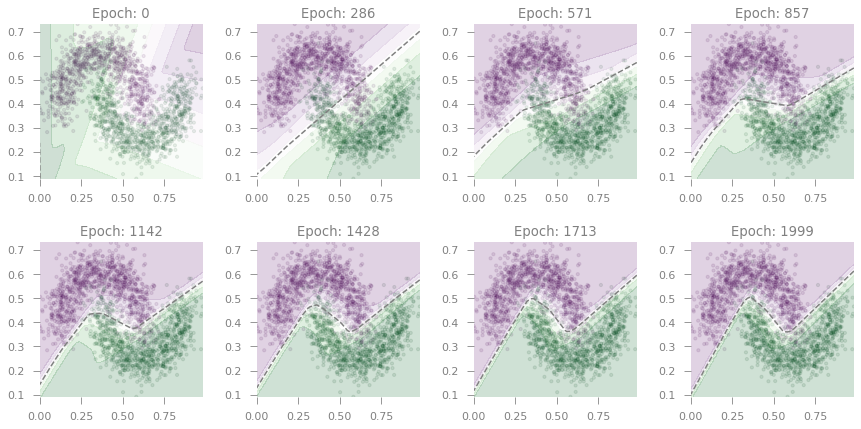

In [1109]:
nn.plot_prediction_boundaries(
    X, 
    y,  
    epochs = np.round(np.linspace(0, len(nn.history) -1, endpoint=True, num = 8), 0).astype('int32').tolist(),
    columns = 4,
    cmap = 'PRGn'
)

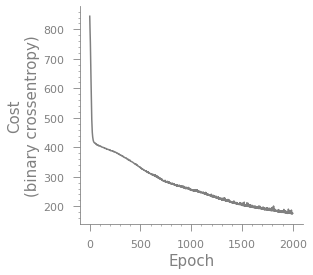

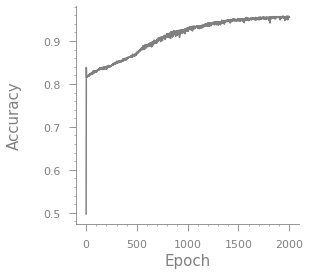

In [1110]:
nn.plot_epoch_stats('cost', 'Cost\n(binary crossentropy)')
nn.plot_epoch_stats('accuracy', 'Accuracy\n')

C:\Users\mp674001\Anaconda3\lib\site-packages\ipykernel_launcher.py:280: UserWarning: No contour levels were found within the data range.


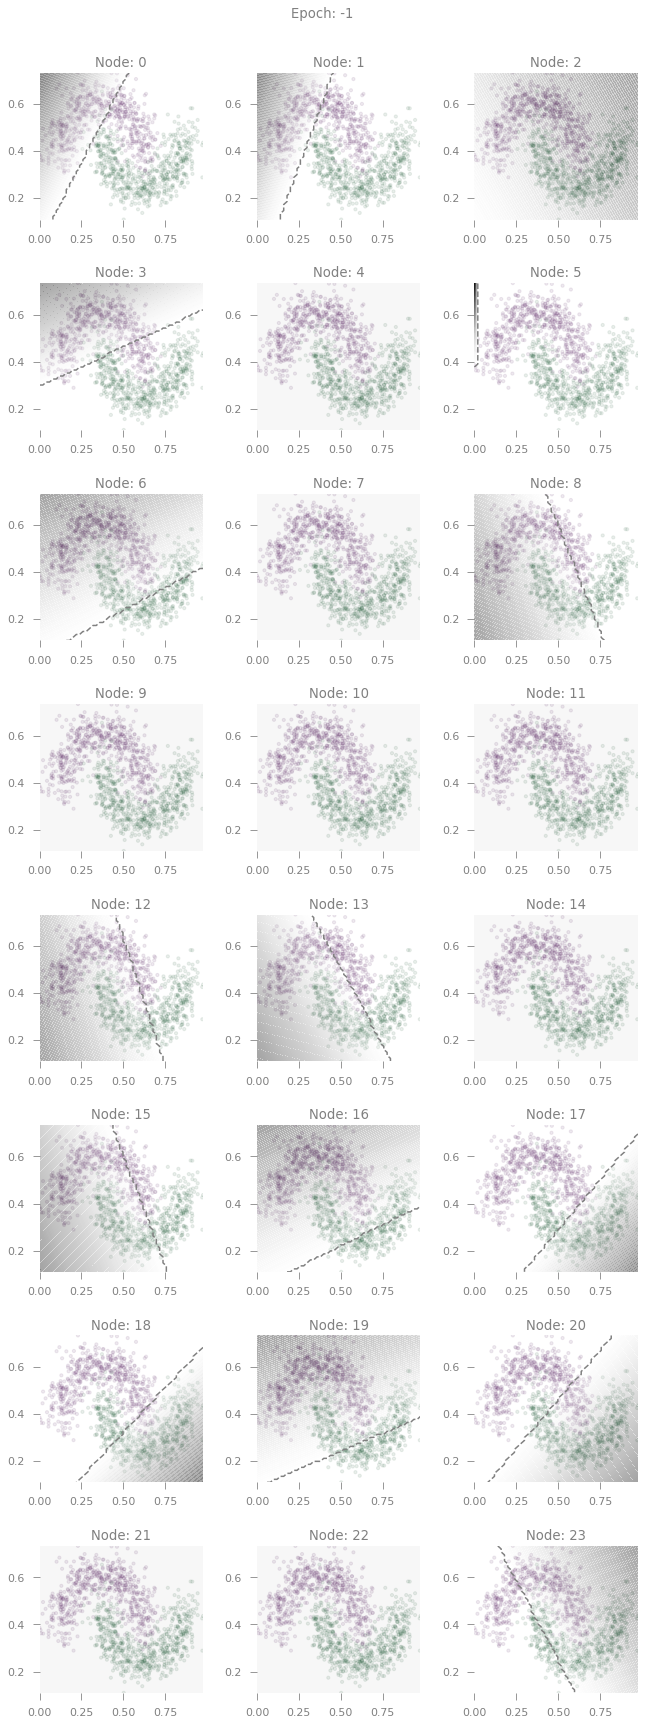

In [1111]:
nn.plot_first_layer_activation(X_train, y_train, epoch = -1, cmap = 'PRGn')

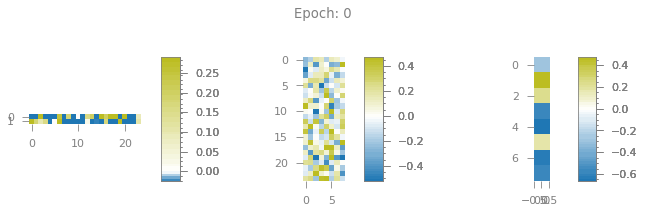

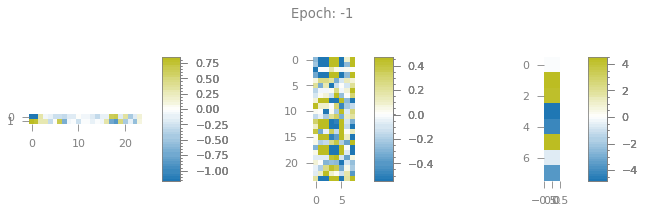

In [1112]:
nn.plot_weights_heatmap(epoch = 0)
nn.plot_weights_heatmap(epoch = -1)